In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Chi-Square Tests: Independence and Goodness-of-Fit

The chi-square test is a statistical method for analyzing categorical data. It compares observed frequencies with expected frequencies to determine whether differences are due to chance or indicate a real effect.

There are two main forms:

1. Chi-Square Test of Independence  
2. Chi-Square Goodness-of-Fit Test  

## 1.1 Chi-Square Test of Independence
- Purpose: Determine if two variables are independent.  
- Method: Construct a contingency table, calculate expected frequencies, and compare them to the observed values.  
- Interpretation:  
  - A large p-value means there is no evidence of association.  
  - A small p-value suggests the variables are associated.



## 1.2 Chi-Square Goodness-of-Fit
- Purpose: Determine if one variable matches an expected distribution.  
- Method: Compare observed frequencies with the expected proportions.  
- Interpretation:  
  - A large p-value means the data matches the expected distribution.  
  - A small p-value means the data deviates from the expected distribution.



# 2. Applications in Healthcare
Let's apply these concepts in the healthcare industry to see if we can obtain some useful results.
1. Independence (Process Association)  
   - Question: Is staffing shift (Day/Night) associated with on-time discharge?  
   - Why it matters: If a relationship exists, staffing or process strategies may need to be adjusted.  

2. Goodness-of-Fit (Feature Screening)  
   - Question: Do observed patient department mixes (ED, Urgent Care, Clinic) match enterprise planning priors?  
   - Why it matters: Deviations may indicate site-specific demand patterns or guide how features are used in forecasting models.  


In [2]:
# 1) Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, chisquare

sns.set(style="whitegrid", palette="muted", font_scale=1.15)
np.random.seed(42)


## 2.1 Simulated Staffing Shift Data
We simulate 1,000 encounters with:
- `Shift` ∈ {Day, Night}
- `OnTimeDischarge` ∈ {Yes, No}
- `Department` ∈ {ED, UrgentCare, Clinic}


In [3]:
# 2.1 Simulate Shift & On-Time Discharge with an association
n = 1000
shifts = np.random.choice(['Day','Night'], size=n, p=[0.6, 0.4])

# Make Day shift more likely to hit on-time discharge (e.g., more ancillary coverage)
p_ontime_day   = 0.72
p_ontime_night = 0.58

ontime = []
for s in shifts:
    p = p_ontime_day if s == 'Day' else p_ontime_night
    ontime.append(np.random.choice(['Yes','No'], p=[p, 1-p]))
ontime = np.array(ontime)

# 2.2 Simulate Department mix (may deviate from corporate priors)
departments = np.random.choice(['ED','UrgentCare','Clinic'], size=n, p=[0.52, 0.28, 0.20])

df = pd.DataFrame({'Shift': shifts, 'OnTimeDischarge': ontime, 'Department': departments})
df.head(20)


,Shift,OnTimeDischarge,Department
0,Day,Yes,ED
1,Night,Yes,ED
2,Night,No,Clinic
3,Day,No,ED
4,Day,No,ED
5,Day,Yes,UrgentCare
6,Day,Yes,ED
7,Night,No,UrgentCare
8,Night,Yes,ED
9,Night,Yes,ED


# 3. EDA (Exploratory Data Analysis)
Quick looks at counts and proportions.


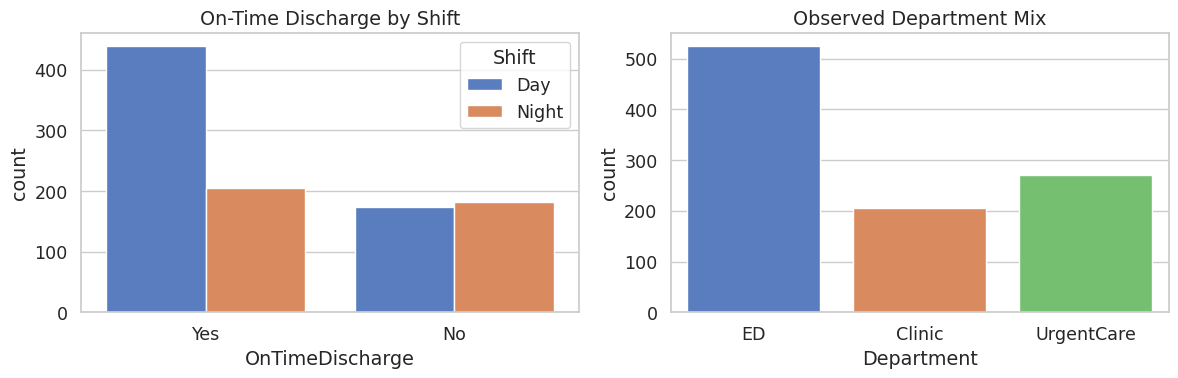

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.countplot(data=df, x='OnTimeDischarge', hue='Shift', ax=axes[0])
axes[0].set_title("On-Time Discharge by Shift")

sns.countplot(data=df, x='Department', ax=axes[1])
axes[1].set_title("Observed Department Mix")

plt.tight_layout()
plt.show()


# 4. Chi-Square Test of Independence (Shift vs. On-Time Discharge)



## Observed vs Expected

The chi-square test of independence works by comparing what we **observe** in the data to what we would **expect** if the two variables had no relationship (were independent).

- **Observed values**: These come directly from the data. For example, the number of patients discharged on time during the day shift.  
- **Expected values**: These are calculated under the assumption that the variables are independent.

### How expected values are calculated

If two variables are independent, the chance of falling into a specific cell in the table should be the product of the marginal proportions.  

For example:
- Suppose 60% of all visits happen during the **Day shift**.  
- And suppose 65% of all patients are discharged **on time**.  
- If shift and discharge are independent, then about **0.60 × 0.65 = 39%** of all records should fall in the "Day shift and On-time discharge" cell.

More generally, the expected value for each cell is:


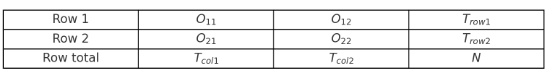

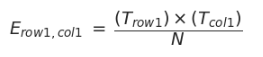

This formula ensures the expected counts preserve the row and column totals, while distributing them as if the two variables had no association.

The chi-square test then asks:  
**Are the observed counts close enough to these expected counts, or are the differences too large to be explained by chance?**

In [5]:
# 4.1 Contingency table
cont = pd.crosstab(df['Shift'], df['OnTimeDischarge'])
print("Contingency Table:\n", cont, "\n")

# 4.2 Test of independence
chi2, p, dof, expected = chi2_contingency(cont, correction=False)
print(f"Chi2: {chi2:.3f} | p-value: {p:.6f} | dof: {dof}")
print("Expected Frequencies:\n", pd.DataFrame(expected, index=cont.index, columns=cont.columns))


Contingency Table:
 OnTimeDischarge   No  Yes
Shift                    
Day              174  439
Night            182  205 

Chi2: 35.966 | p-value: 0.000000 | dof: 1
Expected Frequencies:
 OnTimeDischarge       No      Yes
Shift                            
Day              218.228  394.772
Night            137.772  249.228


Interpretation guide:
- Chi2 is the test statistic. Larger values indicate larger deviations between observed counts and the counts expected under independence.
- If `p < 0.05`, reject independence → Shift is associated with on-time discharge.  
- Recommendations:
  - review discharge workflow by shift
  - adjust staffing for transport/pharmacy/diagnostics
  - stagger rounding times, etc.


# 5. Chi-Square Goodness-of-Fit (Department Mix vs Planning Priors)

Context:

Let's assume the head office expects patient visits to break down across departments in a certain way. 
- For example, 50% Emergency Department, 30% Urgent Care, and 20% Clinic.

At our site, we’ve recorded the actual visits. The question is:
Does what we actually see match what the planners expected, or is our mix different?

- Observed counts from `df['Department']`.
- Expected counts from priors (example):  
  - ED: 50%, Urgent Care: 30%, Clinic: 20


Why does this matter for feature selection?

- If the way a category (like department type) shows up at one site is very different from what the organization expected, it tells us something important.  
- That difference could mean the category holds useful information about that site (a signal we want to keep when building a model).  
- Or, if the categories are too uneven or unstable, we might need to group them differently so the model does not get confused or make unreliable predictions.



In [6]:
# 5.1 Observed counts
obs_counts = df['Department'].value_counts().reindex(['ED','UrgentCare','Clinic']).fillna(0).astype(int).values

# 5.2 Expected counts from enterprise priors
priors = np.array([0.50, 0.30, 0.20])  # ED, UrgentCare, Clinic
exp_counts = priors * n

# 5.3 GOF test
chi2_gof, p_gof = chisquare(f_obs=obs_counts, f_exp=exp_counts)

dept_df = pd.DataFrame({
    'Department': ['ED','UrgentCare','Clinic'],
    'Observed': obs_counts.astype(int),
    'Expected': exp_counts.astype(int)
})

print(dept_df)
print(f"\nGoodness-of-Fit Chi2: {chi2_gof:.3f} | p-value: {p_gof:.6f} | dof: {len(obs_counts)-1}")


   Department  Observed  Expected
0          ED       525       500
1  UrgentCare       270       300
2      Clinic       205       200

Goodness-of-Fit Chi2: 4.375 | p-value: 0.112197 | dof: 2


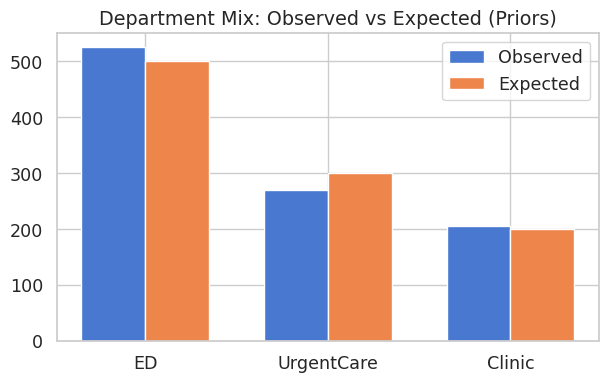

In [13]:
# 5.4 Visualize observed vs expected
x = np.arange(len(dept_df))
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, dept_df['Observed'], width, label='Observed')
plt.bar(x + width/2, dept_df['Expected'], width, label='Expected')
plt.xticks(x, dept_df['Department'])
plt.title("Department Mix: Observed vs Expected (Priors)")
plt.legend()
plt.show()


**Interpretation guide:**  
- If `p < 0.05`, the site’s department mix differs from priors.
- In this case, there is not enough evidence to indicate that the observed distribution of patient visits is different from the expected results.  
- Recommendation:  
  - Keep *Department* as a strong feature (it carries site-specific signal).  
  - Revisit capacity plans and staffing allocations by department.  
  - Consider re-bucketing rare categories in other features where GOF shows extreme skew (stability for ML).


## 6) Using Chi-Square for Feature Screening

When working with categorical features, chi-square tests can help you decide which ones are useful in a model.

1. Checking association with the outcome (Independence test):  
   For each feature (for example, `Department` or `Shift`), build a table that compares it to the target variable (like `OnTimeDischarge`).  
   - If the p-value is small, it means the feature and the target are likely related. In this case, keep the feature.

2. Checking stability compared to expectations (Goodness-of-Fit test):  
   Compare the distribution of a feature at your site to what was expected from company-wide data or past history.  
   - If the observed distribution is very different from the expected one, that tells you something:  
     - It could be a useful signal (your site behaves differently than average).  
     - Or, if the categories are too unbalanced or inconsistent, you may need to group them differently before modeling to avoid unstable results.


In [9]:
# 6.1 Independence screens for multiple categorical features vs outcome
cat_features = ['Shift','Department']  # add others if present
results = []
for col in cat_features:
    ct = pd.crosstab(df[col], df['OnTimeDischarge'])
    chi2_i, p_i, dof_i, _ = chi2_contingency(ct, correction=False)
    results.append((col, chi2_i, p_i, dof_i, ct.sum().sum()))
    
pd.DataFrame(results, columns=['Feature','Chi2','p_value','dof','N']).sort_values('p_value')


,Feature,Chi2,p_value,dof,N
0,Shift,35.965599,2.008321e-09,1,1000
1,Department,6.249693,4.394369e-02,2,1000


## 7) Summary
- **Independence test** quickly reveals process associations (e.g., shift → on-time discharge).  
- **Goodness-of-fit** flags when your site’s demand mix diverges from planning priors—useful for capacity planning and deciding how to encode or re-bucket features.  
- Together, they provide light-weight diagnostics for operational changes and model-ready feature screening.
